## Lesson 2 
in this class we'll learn how to exploit the `random` functionalities of python to handle distributions. Most of the functions will be in the module `np.random` https://numpy.org/doc/2.1/reference/random/index.html  


- uniform distribution : np.random.uniform 
- normal     "         : np.random.normal 
- Poisson     "        : np.random.poisson 


In [2]:
import numpy as np
import pylab as pl 
from scipy.optimize import curve_fit
from lab3_utils import red_chi_squared, gaussian 

### Uniform distributions 

### Exercise 
- plot a normalized histogram of the distribution with 100 bins 
-   Generate different distributions with different choices of the `size` parameters 
-   plot the histograms into a single plot 


In [35]:
v =np.random.uniform( low=-1,high =1 ,  size= 4000  )

### Your code here ... 

### Non-uniform distributions 

### Exercise on Normal distr.  
 - plot a normalized histogram of the distribution with 100 bins 
 -  fit a gaussian function over the distribution (hint use the lesson_0 notebook to refresh your memory  ;-D ) 
 -  estimate the $\chi^2$ to assess the quality of the fit  

In [35]:
v =np.random.normal( loc=-1,scale  =1 ,  size= 4000  )

### Your code here ... 

### Exercise on Poisson distr. 
  
 -   Generate different distributions with different choices of the `lam` parameter, 
 -   plot the histograms into a single plot 
 -   discuss how the distribution change.   

In [35]:
v =np.random.poisson(lam=3 , size= 400  )
### Your code here ... 

## Sample from any distribution
#### Rejection Sampling 

0. Sample a point on the  x‑axis from the proposal distribution.
1. Draw a vertical line at this x‑position, up to the $PDF(x)$-value  of the proposal distribution.
2. Sample a y-value uniformly along this line from 0 to $PDF(x)$. 
3.   If $y>PDF(x) $ **reject** x and go back  to step 0; 
    else **accept**  x 

Let's assume a sine weighted distribution 

In [71]:
def rejection( n ):
    accepted = 0
    rejected = 0
    total =0
    accepted_x = []
    while accepted < n:
        total+=1 
        ux = np.random.uniform(0, np.pi)
        uy = np.random.uniform(0, 1)
        if uy > np.sin(ux):
            rejected += 1
            continue
        accepted += 1
        accepted_x.append(ux)
    return accepted_x,accepted, rejected , total 
 
N = int(1e5)   

accepted_x,accepted, rejected , total= rejection (N) 
print(total )




157139


... or in a more _pythonic_ way (avoiding the while loop ....) 

In [69]:
xvals = np.random.uniform(0, np.pi, N)   
PDF  = np.sin(xvals)   
yvals = np.random.uniform(0,1, N) 

mask_rejected = yvals  > PDF  
rejected = xvals[mask_rejected ].size
accepted = xvals[np.logical_not(mask_rejected)  ].size 
accepted_x = xvals[~ mask_rejected ]




63506 63506 36494


Red chi2 :0.916
Rejection fraction = 0.3649
Theoretical rejection = 0.3634
Fit parameter A = 997.1159


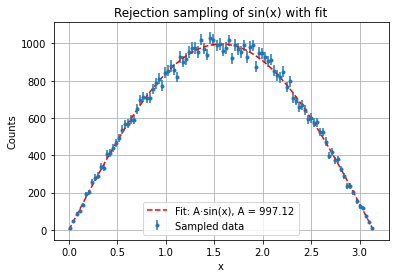

In [70]:
sin_func= lambda x, A: A * np.sin(x)
# Costruiamo l'istogramma per il fit
counts, bin_edges = np.histogram(accepted_x, bins=100, range=(0, np.pi), density=False)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    # Fit con A * sin(x)
popt, pcov = curve_fit(sin_func, bin_centers, counts)
A_fit = popt[0]

plt.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label='Sampled data', markersize=3)
x_fit = np.linspace(0, np.pi, 500)
y_fit = sin_func(x_fit, A_fit)
plt.plot(x_fit, y_fit, 'r--', label=f'Fit: A·sin(x), A = {A_fit:.2f}')
plt.title("Rejection sampling of sin(x) with fit")
plt.xlabel("x")
plt.ylabel("Counts")
plt.grid(True)
plt.legend()
# Risultati
rejection_fraction = rejected / N
theoretical = (np.pi - 2) / np.pi
print(f"Red chi2 :{red_chi_squared(y_exp=counts , y_obs = sin_func(bin_centers, A_fit), n_params=1, errors=np.sqrt(counts) ):.3f}")

print(f"Rejection fraction = {rejection_fraction:.4f}")
print(f"Theoretical rejection = {theoretical:.4f}")
print(f"Fit parameter A = {A_fit:.4f}")


####  Inverse Sampling  

generate samples from a power law  
-  be $x$ a variable distributed with a certain PDF $P(x) \propto x^{\alpha}$  and Cumulative Distribution Function $C (x>t)= \int_0 ^x P(t)dt  $ 
- Generate a uniform random number $u$ in the interval [0,1] 
- Find the generalized inverse of the desired CDF, i.e. $CDF^{-1}(u) $ 
- Compute a random variable  $\tilde{x}= CDF^{-1}(u) $ that is distributed as $x$


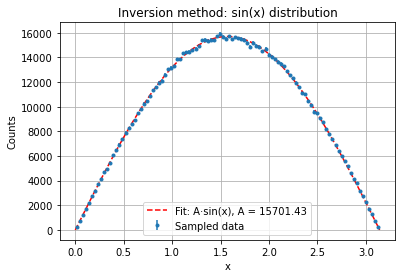

Elapsed time: 0.08 s
Fit parameter A = 15701.4266
ChiSquare / Ndf = 0.9603


In [7]:
def inversion():
    n = int(1e6)
    start_time = time.time()

    # Genera u uniformemente distribuiti in [-1, 1], poi x = arccos(u)
    u = np.random.uniform(-1, 1, n)
    x = np.arccos(u)

    elapsed_time = time.time() - start_time

    # Istogramma
    counts, bin_edges = np.histogram(x, bins=100, range=(0, np.pi), density=False)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    # Fit con A * sin(x)
    popt, pcov = curve_fit(sin_func, bin_centers, counts)
    A_fit = popt[0]

    # Valori del fit per calcolo chi²
    expected = sin_func(bin_centers, A_fit)
    observed = counts
    errors = np.sqrt(observed)
    errors[errors == 0] = 1  # evita divisione per zero

    chi2 = np.sum(((observed - expected) ** 2) / (errors ** 2))
    ndf = len(observed) - 1  # 1 parametro nel fit
    chi2_ndf = chi2 / ndf

    # Plot
    plt.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', markersize=3, label='Sampled data')
    x_fit = np.linspace(0, np.pi, 500)
    y_fit = sin_func(x_fit, A_fit)
    plt.plot(x_fit, y_fit, 'r--', label=f'Fit: A·sin(x), A = {A_fit:.2f}')
    plt.title("Inversion method: sin(x) distribution")
    plt.xlabel("x")
    plt.ylabel("Counts")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Output
    print(f"Elapsed time: {elapsed_time:.2f} s")
    print(f"Fit parameter A = {A_fit:.4f}")
    print(f"ChiSquare / Ndf = {chi2_ndf:.4f}")

# Esegui la funzione
inversion()
